In [30]:
from __future__ import print_function, division

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
# from torch.optim import lr_scheduler
from torch.optim import Adam
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from load_dataset import BangladeshDataset
from utils import torch_to_im_show
import matplotlib.pyplot as plt
import time
import os
import gdal

gdal.SetCacheMax(2**30) # 1 GB

plt.ion()   # interactive mode
%matplotlib inline

In [31]:
#train_data_dir = '/mnt/staff-bucket/'
#val_data_dir = '/mnt/staff-bucket/'

train_data_dir = '/home/echartock03/data/l8_2015'
val_data_dir = '/home/echartock03/data/l8_2015'

train_bangladesh_csv_path = '/home/echartock03/predicting-poverty/data/bangladesh_2015_train.csv'
val_bangladesh_csv_path = '/home/echartock03/predicting-poverty/data/bangladesh_2015_valid.csv'

train_dataset = BangladeshDataset(csv_file=train_bangladesh_csv_path,
                                           root_dir=train_data_dir)
val_dataset = BangladeshDataset(csv_file=val_bangladesh_csv_path,
                                           root_dir=val_data_dir)

image_datasets = {'train': train_dataset, 'val': val_dataset}

0 (500, 500, 3) 26.9630147052
1 (500, 500, 3) 35.6489274569
2 (500, 500, 3) 28.7652674594
3 (500, 500, 3) 75.8910514074


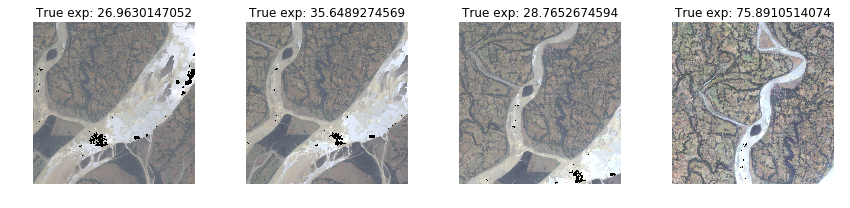

In [32]:
# visualize a few images from training set
fig = plt.figure(figsize=(12, 3))

for i in range(len(image_datasets['val'])):
    image, label = image_datasets['val'][i]
    image = np.array(image)

    print(i, image.shape, label)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('True exp: {}'.format(label))
    ax.axis('off')
    
    # expects images with shape image.shape = (500, 500, 3)
    plt.imshow(image)
    plt.pause(0.001)  # pause a bit so that plots are updated

    if i == 3:
        plt.show()
        break

In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train_data_dir = '/home/echartock03/data/l8_2015'
val_data_dir = '/home/echartock03/data/l8_2015'

train_bangladesh_csv_path = '/home/echartock03/predicting-poverty/data/bangladesh_2015_train.csv'
val_bangladesh_csv_path = '/home/echartock03/predicting-poverty/data/bangladesh_2015_valid.csv'


train_dataset = BangladeshDataset(csv_file=train_bangladesh_csv_path,
                                           root_dir=train_data_dir,
                                           transform=data_transforms['train'])
val_dataset = BangladeshDataset(csv_file=val_bangladesh_csv_path,
                                           root_dir=val_data_dir,
                                           transform=data_transforms['val'])

image_datasets = {'train': train_dataset, 'val': val_dataset}

dataloders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=False, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [34]:
model_conv = torchvision.models.resnet18(pretrained=False)
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 1)
# Print network modules with names
for idx, m in enumerate(model_conv.named_modules()):
    print(idx, '->', m)

0 -> ('', ResNet (
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU (inplace)
  (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential (
    (0): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): B

In [38]:
#for idx, m in enumerate(model_conv.named_modules()):
#    print(idx, '->', m)
for name, param in model_conv.named_parameters():
   print(param.size(), '->', name)

torch.Size([64, 3, 7, 7]) -> conv1.weight
torch.Size([64]) -> bn1.weight
torch.Size([64]) -> bn1.bias
torch.Size([64, 64, 3, 3]) -> layer1.0.conv1.weight
torch.Size([64]) -> layer1.0.bn1.weight
torch.Size([64]) -> layer1.0.bn1.bias
torch.Size([64, 64, 3, 3]) -> layer1.0.conv2.weight
torch.Size([64]) -> layer1.0.bn2.weight
torch.Size([64]) -> layer1.0.bn2.bias
torch.Size([64, 64, 3, 3]) -> layer1.1.conv1.weight
torch.Size([64]) -> layer1.1.bn1.weight
torch.Size([64]) -> layer1.1.bn1.bias
torch.Size([64, 64, 3, 3]) -> layer1.1.conv2.weight
torch.Size([64]) -> layer1.1.bn2.weight
torch.Size([64]) -> layer1.1.bn2.bias
torch.Size([128, 64, 3, 3]) -> layer2.0.conv1.weight
torch.Size([128]) -> layer2.0.bn1.weight
torch.Size([128]) -> layer2.0.bn1.bias
torch.Size([128, 128, 3, 3]) -> layer2.0.conv2.weight
torch.Size([128]) -> layer2.0.bn2.weight
torch.Size([128]) -> layer2.0.bn2.bias
torch.Size([128, 64, 1, 1]) -> layer2.0.downsample.0.weight
torch.Size([128]) -> layer2.0.downsample.1.weight
t

In [39]:
model_conv.load_state_dict(torch.load("../models/bangladesh_l8.model"))

In [42]:
# visualize a few images from training set
fig = plt.figure(figsize=(12, 3))

images, labels = next(iter(dataloders['val']))
#torch_to_im_show(images)
inputs = Variable(images)
outputs = model_conv(inputs)
preds = outputs.data[:, 0]

print(labels)
print(preds)


 26.9630
 35.6489
 28.7653
 75.8911
[torch.DoubleTensor of size 4]


 44.5887
 34.4137
 42.0697
 47.4493
[torch.FloatTensor of size 4]

